In [13]:
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import tcpyPI

import interpolate
from load_SAIdata import Cases

In [15]:
ds = Cases('hres.ref.1').select('atm','h0').open_mfdataset()
ds = ds.isel(time=0, lat=slice(None,None,4), lon=slice(None,None,4))

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h0.2002-12_2012-12.json


In [16]:
%%time

# interpolate T and Q to pressure levels in hPa
PLEV = np.append(interpolate.PLEV/100, [1010,1020,1030])#,1040,1050])
#PLEV = interpolate.PLEV/100
P = interpolate.pressure_from_hybrid(ds) / 100
T = interpolate.interpolate(ds.T, P, PLEV, 'lev').compute()
Q = interpolate.interpolate(ds.Q, P, PLEV, 'lev').compute()

# plev must be descending with increasing index
T = T.isel(plev=slice(None, None, -1))
Q = Q.isel(plev=slice(None, None, -1))

# convert to required units
T = (T-273.15).assign_attrs({'units':'°C'})
Q = (Q*1000).assign_attrs({'units':'g/kg'})
TS = (ds.TS - 273.15).assign_attrs({'units':'°C'}).compute()
PSL = (ds.PSL/100).assign_attrs({'units':'hPa'}).compute()

# mask land
TS = TS.where(ds.OCNFRAC>=0.9)

CPU times: user 916 ms, sys: 620 ms, total: 1.54 s
Wall time: 1.75 s


In [24]:
%%time
vmax, pmin, ifl, t0, otl = xr.apply_ufunc(
    tcpyPI.pi,
    TS,
    PSL,
    T.plev,
    T,
    Q,
    kwargs={'miss_handle':1},
    input_core_dims=[[],[],['plev'],['plev'],['plev']],
    output_core_dims=[[],[],[],[],[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[T.dtype]*5,
)

CPU times: user 68.3 ms, sys: 5.85 ms, total: 74.2 ms
Wall time: 73.4 ms


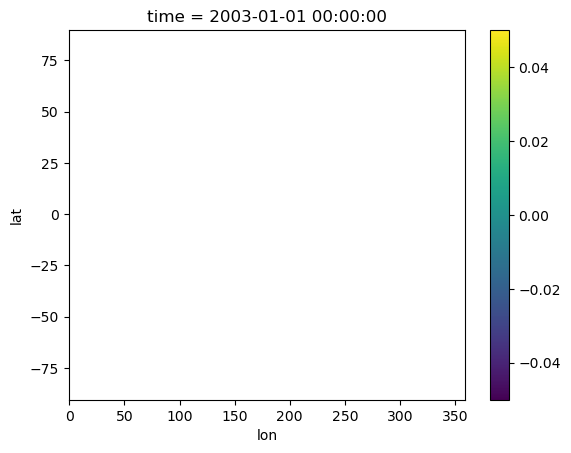

In [25]:
pmin.plot()

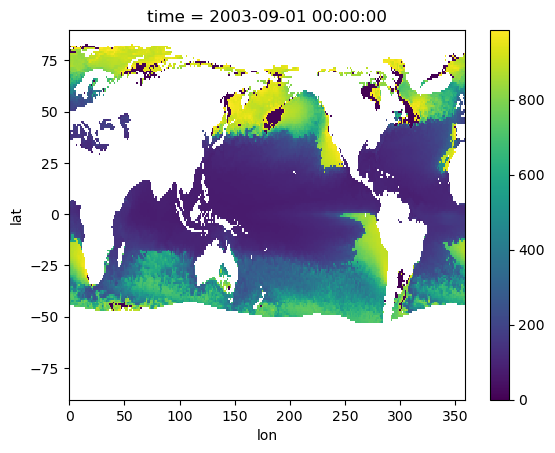

In [46]:
otl.plot()

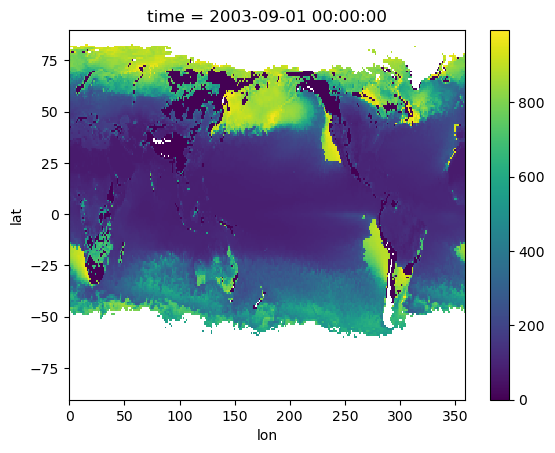

In [67]:
otl.plot()

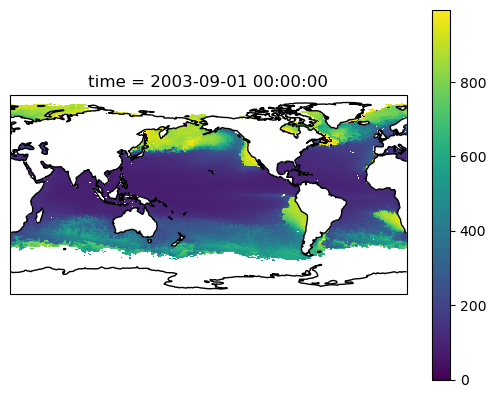

In [88]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
otl.where(ds.OCNFRAC>=0.9).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

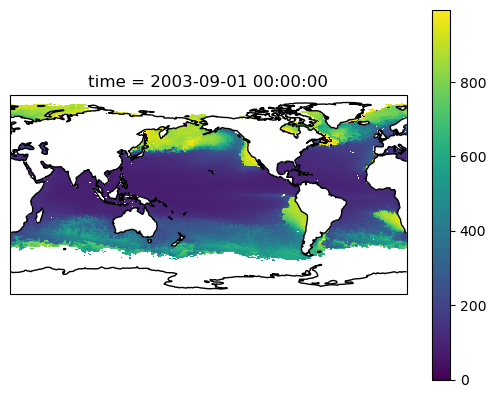

In [87]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
otl.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

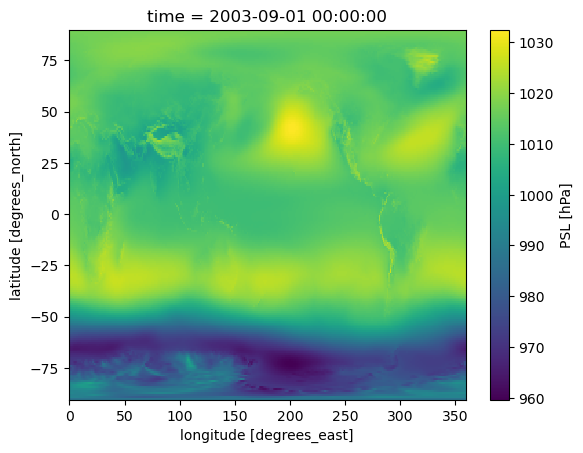

In [89]:
PSL.plot()

In [10]:
ds = xr.open_dataset('../jobs/PI/data/PI.hres.ref.1.nc')

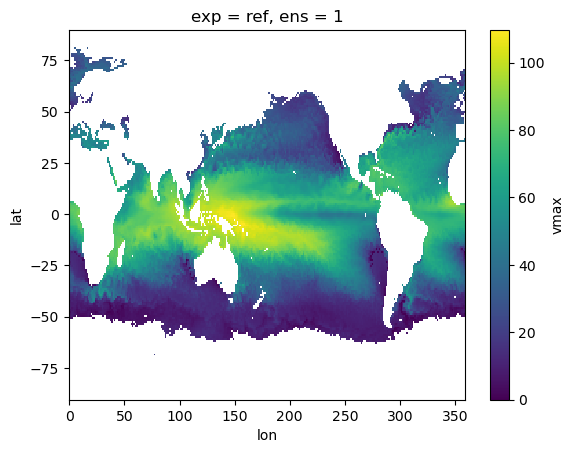

In [11]:
ds.vmax.mean('month').plot()

In [23]:
(lnpi, lneff, lndiseq, lnCKCD) = xr.apply_ufunc(
    tcpyPI.decompose_pi,
    ds.vmax,
    ds.TS+273.15,
    ds.t0,
    input_core_dims=[[],[],[]],
    output_core_dims=[[],[],[],[]],
    vectorize=True,
)

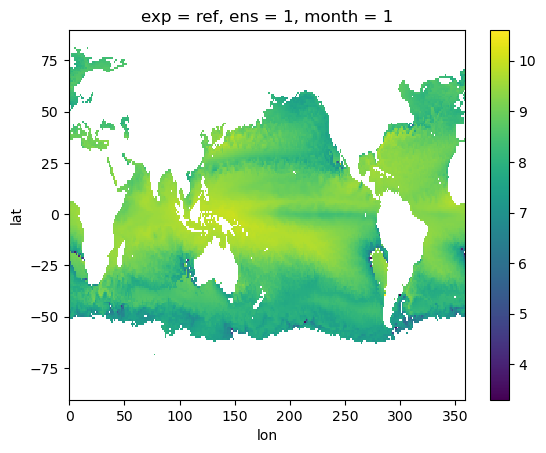

In [35]:
lndiseq.plot()

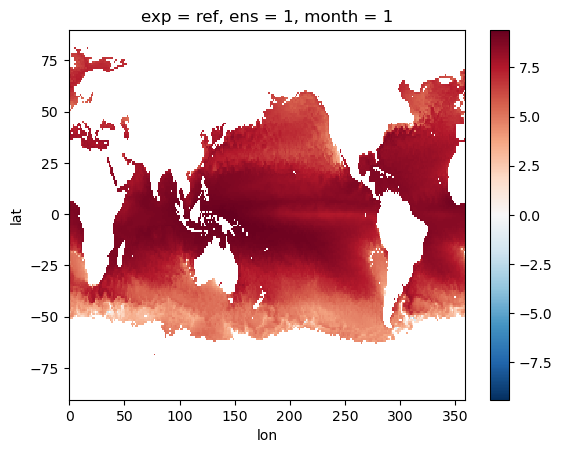

In [36]:
lnpi.plot()

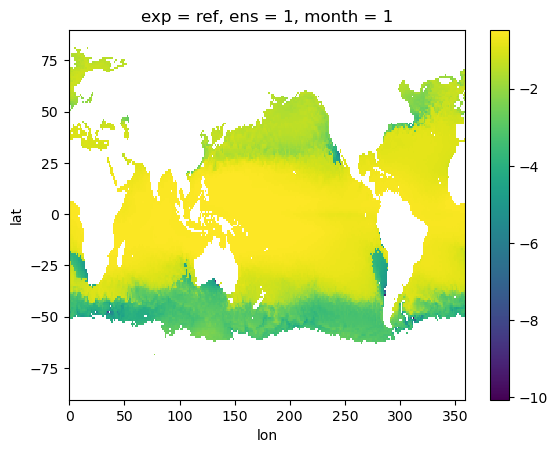

In [37]:
lneff.plot()

In [44]:
ds = xr.open_dataset('../jobs/PI/data/PI.hres.ref.1.nc')

In [49]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (month: 12, lat: 48, lon: 72, plev: 38)
Coordinates:
  * lat      (lat) float64 384B -88.24 -84.49 -80.73 ... 80.73 84.49 88.24
  * lon      (lon) float64 576B 2.344 7.344 12.34 17.34 ... 347.3 352.3 357.3
    exp      <U3 12B ...
    ens      int64 8B ...
  * plev     (plev) float64 304B 1.04e+03 1.03e+03 1.02e+03 ... 7.595 3.643
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TS       (month, lat, lon) float32 166kB ...
    OCNFRAC  (month, lat, lon) float32 166kB ...
    vmax     (month, lat, lon) float32 166kB ...
    t0       (month, lat, lon) float32 166kB ...
    otl      (month, lat, lon) float32 166kB ...
    lnpi     (month, lat, lon) float32 166kB ...
    lneff    (month, lat, lon) float32 166kB ...
    lndiseq  (month, lat, lon) float32 166kB ...
    lnCKCD   float64 8B ...
    gw       (lat) float64 384B ...
Attributes:
    Conventions:      CF-1.0
    Version:          $Name$
    case:             b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001
    host:             tcn127.bullx
    initial_file:     /projects/0/prace_imau/prace_2013081679/cesm1_0_4/input...
    logname:          klipdccp
    revision_Id:      $Id$
    source:           CAM
    title:            UNSET
    topography_file:  /projects/0/prace_imau/prace_2013081679/cesm1_0_4/input...

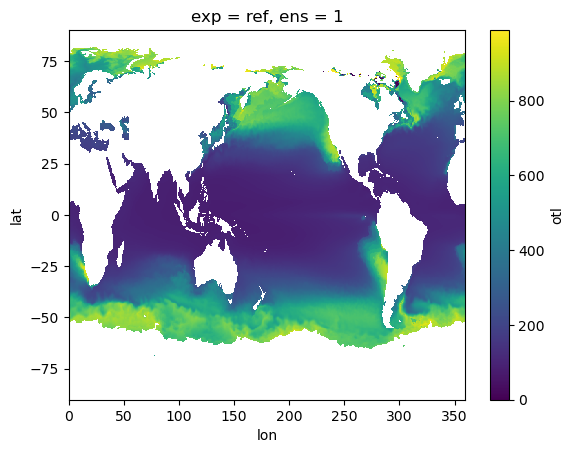

In [9]:
ds.otl.mean('month').coarsen(lat=2,lon=2).mean().plot()

In [12]:
ds.dtypes

Frozen({'TS': dtype('float32'), 'OCNFRAC': dtype('float32'), 'gw': dtype('float64'), 'vmax': dtype('float64'), 'pmin': dtype('float64'), 'ifl': dtype('float64'), 't0': dtype('float64'), 'otl': dtype('float64'), 'lnpi': dtype('float64'), 'lneff': dtype('float64'), 'lndiseq': dtype('float64'), 'lnCKCD': dtype('float64')})

In [51]:
ds = xr.open_dataset('../jobs/PI/data/PI.nc')

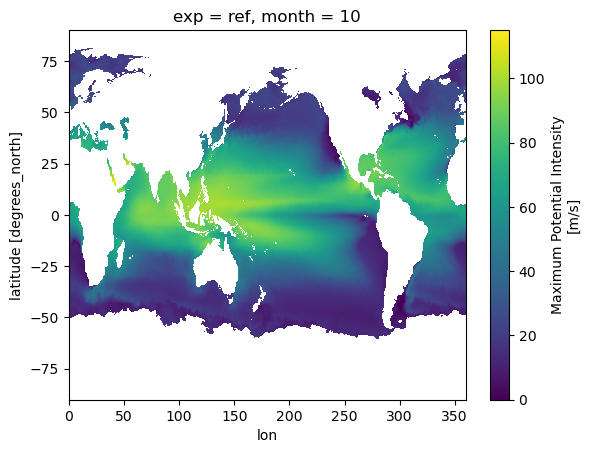

In [53]:
ds.vmax.sel(exp='ref', month=10).plot()

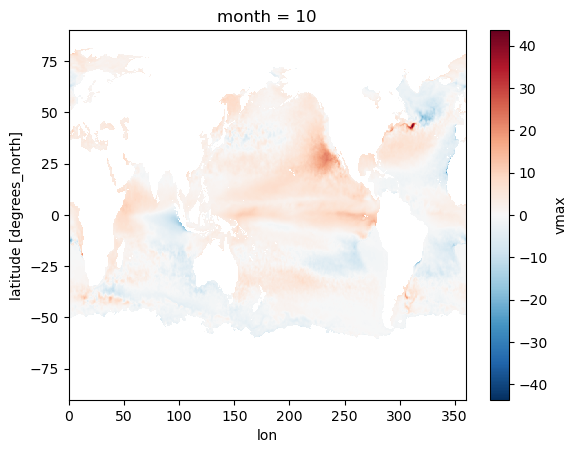

In [54]:
(ds.vmax.sel(exp='cnt',month=10)-ds.vmax.sel(exp='ref',month=10)).plot()

In [14]:
# This pyPI script computes PI and associated analyses over the entire sample dataset
# which is from 2004, MERRA2.
#
# Created by Daniel Gilford, PhD (daniel.gilford@rutgers.edu)
# Many thanks to Daniel Rothenberg for his assitance optimizing pyPI
#
# Last updated 8/14/2020
#

# setup
import xarray as xr

# load in pyPI modules
from tcpyPI import pi, log_decompose_pi
from tcpyPI.utilities import pi_efficiency, pi_diseq_resid

# define the sample data locations
datdir='./data/'
_FN=datdir+'sample_data.nc'
    

def run_sample_dataset(fn, dim='p',CKCD=0.9,outflow_source="cape_star"):
    """Calculate potential intensity over the sample dataset with xarray.

    Parameters
    ----------
    fn : str
        Path to the input dataset (e.g., `data/sample_data.nc`).
    dim : str, default="p"
        Name of the vertical pressure coordinate in `fn`.
    CKCD : float, default=0.9
        Ratio of exchange coefficients (Ck/Cd).
    outflow_source : {"cape_star", "cape_env"}, default="cape_star"
        Which CAPE calculation supplies the outflow temperature and level.

    Returns
    -------
    xarray.Dataset
        Dataset containing PI outputs (`vmax`, `pmin`, `ifl`, `t0`, `otl`) and the
        state variables used in the calculation.
    """
    
    # open the sample data file
    ds = xr.open_dataset(fn)
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds[dim], ds['t'], ds['q'],
        kwargs=dict(
            CKCD=CKCD,
            ascent_flag=0,
            diss_flag=1,
            ptop=50,
            miss_handle=1,
            outflow_source=outflow_source,
        ),
        input_core_dims=[
            [], [], [dim, ], [dim, ], [dim, ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )

    # store the result in an xarray data structure
    vmax, pmin, ifl, t0, otl = result
    out_ds=xr.Dataset({
        'vmax': vmax, 
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'otl': otl,
        # merge the state data into the same data structure
        'sst': ds.sst,
        't': ds.t,
        'q': ds.q,
        'msl': ds.msl,
        'lsm': ds.lsm,
        })
    
    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

    # return the output from pi.py as an xarray data structure
    return out_ds

def run_sample_analyses(ds,CKCD=0.9):
    """Compute analysis diagnostics (including log decomposition) on PI outputs.

    Parameters
    ----------
    ds : xarray.Dataset
        Output from :func:`run_sample_dataset`.
    CKCD : float, default=0.9
        Ratio of exchange coefficients (Ck/Cd).

    Returns
    -------
    xarray.Dataset
        Dataset of diagnostics: `eff`, `diseq`, `lnpi`, `lneff`, `lndiseq`, `lnCKCD`.
    """
    
    # calculate PI analyses over the whole data set using the xarray universal function
    efficiency = xr.apply_ufunc(
        pi_efficiency,
        ds['sst']+273.15, ds['t0'],
        input_core_dims=[
            [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    diseq = xr.apply_ufunc(
        pi_diseq_resid,
        ds['vmax'], ds['sst']+273.15, ds['t0'],
        kwargs=dict(CKCD=CKCD),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    result = xr.apply_ufunc(
        log_decompose_pi,
        ds['vmax'], ds['sst']+273.15, ds['t0'],
        kwargs=dict(CKCD=CKCD, sst_units="K"),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [], [], [], [],
        ],
        vectorize=True
    )

    lnpi, lneff, lndiseq, lnCKCD = result
    
    out_ds = xr.Dataset({
                'eff': efficiency, 
                'diseq': diseq,
                'lnpi': lnpi,
                'lneff': lneff,
                'lndiseq': lndiseq,
                'lnCKCD': lnCKCD[0,0,0]
            })
    
    # add names and units (where applicable)
    out_ds.eff.attrs['standard_name'],out_ds.eff.attrs['units']='Tropical Cyclone Efficiency','unitless fraction'
    out_ds.diseq.attrs['standard_name'],out_ds.diseq.attrs['units']='Thermodynamic Disequilibrium','J/kg'
    out_ds.lnpi.attrs['standard_name']='Natural log(Potential Intensity)'
    out_ds.lneff.attrs['standard_name']='Natural log(Tropical Cyclone Efficiency)'
    out_ds.lndiseq.attrs['standard_name']='Natural log(Thermodynamic Disequilibrium)'
    out_ds.lnCKCD.attrs['standard_name'],out_ds.lnCKCD.attrs['units']='Natural log(Ck/CD)','unitless constant'

    # return the output from pi.py as an xarray data structure
    return out_ds
    
    

if __name__ == "__main__":

    # Execute PI analysis over the whole dataset and save the output
    print('Beginning PI computations...')
    ds = run_sample_dataset(_FN)
    ds.to_netcdf(datdir+'raw_sample_output.nc')
    print('...PI computation complete and saved\n')
    
    # Perform PI analyses over the whole dataset
    print('Performing PI analyses...')
    ds2 = run_sample_analyses(ds,CKCD=0.9)
    
    # merge the arrays and save the output
    ds3=ds.merge(ds2)
    ds3.to_netcdf(datdir+'full_sample_output.nc')
    del ds, ds2
    print('...PI analyses complete and saved')
    print('pyPI sample run finished!')

numba.core.registry.CPUDispatcher